# The Area Under the Curve of the Receiver Operating Characteristic

In this notebook we'll explore the notion of the receiver operating characteristic. Let's import some tools.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import numpy as np
from matplotlib import pyplot as plt

## Data

First let's generate some data using sklearn's make_classification tool:

In [2]:
X, y = make_classification(n_samples=10000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Model

Now we'll fit a LogisticRegression object:

In [4]:
logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train_sc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Predictions

***`.predict()` vs. `.predict_proba()`***

In [12]:
logreg.predict_proba(X_test_sc)[:5]

array([[0.15656913, 0.84343087],
       [0.04120804, 0.95879196],
       [0.00404192, 0.99595808],
       [0.01930912, 0.98069088],
       [0.52655438, 0.47344562]])

In [13]:
logreg.predict(X_test_sc)[:5]

array([1, 1, 1, 1, 0])

## Confusion Matrix

In [14]:
cm = confusion_matrix(y_test, logreg.predict(X_test_sc))

In [15]:
cm

array([[1115,  136],
       [ 135, 1114]])

Defining true/false positives/negatives:

In [16]:
tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]

## AUC-ROC

The Receiver Operating Characteristic curve plots the true-positive rate vs. the false-positive rate. Let's define these now:

In [17]:
tpr = tp / (tp + fn) # true positive rate
fpr = fp / (fp + tn) # false positive rate

### Thresholds

Wait. How does this make sense? Doesn't a classifier just have a certain number of true positives, false positives, and all the rest? And so wouldn't a "plot" of these rates just be a single point on a graph?

Consider a prediction for a particular data point. The features have particular values that lead the model to predict 0 or 1, one way or the other. But the model doesn't merely spit out 0's and 1's: As we just saw, there is a *calculation* done here. Let's look again at the predicted probabilities of class membership for a particular point:

In [18]:
logreg.predict_proba(X_test_sc)[0]

array([0.15656913, 0.84343087])

Now the default behavior is simply to take the larger of these values as the "real" prediction. Since $0.84 > 0.16$, we'll understand the model to be predicting this point to belong to class "1" (or the positive class). An equivalent way of understanding the default behavior is that we:

- round the predicted numbers up to 1 if they are at least as large as 0.5; and
- round them down to 0 if they are less than 0.5.

Since the probabilities must sum to 1, there will never be any problem with this algorithm.

But we don't have to do things this way. Suppose we're building a model that predicts the presence of prostate cancer from X-ray scans of prostates. And suppose we get a pair of probabilities for some particular scan that look like this:

- pred_neg: 0.52, pred_pos: 0.48

Because false negatives (cancerous prostates mislabeled) are *much* more costly than false positives (non-cancerous prostates mislabeled), we may well want to **adjust our threshold** of classification. We might want to have our model predict "positive" if the corresponding probability is, say, as low as 0.4, or maybe even as low as 0.1. (Speaking for myself, if there was even a 10% chance that my prostate was cancerous, I think I'd probably want to know about it.)

Clearly, the true- and false-positive rates will change if we make this adjustment to the threshold. In fact, in the present case that was the whole point of making the adjustment: We want to minimize our false negatives.

So this is how the plot of these rates takes shape.

Let's build a function that will take in our data, together with a threshold setting, and return the corresponding true- and false-positive rates.

In [19]:
def classify_rates(X_train, X_test, y_train, y_test, thresh):
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train, y_train)
    y_hat_probs = logreg.predict_proba(X_test)
    y_hat = []
    for val in y_hat_probs:                                 # Each element in y_hat_probs is an array.
        if val[0] < thresh:                                 # We'll set our own threshold for classifying
            y_hat.append(1)                                 # a test point as positive! The lower my threshold,
        else:                                               # the fewer predicted positives I'll have. For the
            y_hat.append(0)                                 # cancer example, I'd want to set a *high* threshold.
    cm = confusion_matrix(y_test, y_hat)
    tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr, f'tpr:{round(tpr, 3)}, fpr:{round(fpr, 3)}'

True- and false-positive rates for various thresholds:

In [20]:
for x in np.linspace(0, 1, 11):
    print(f'Rates at threshold = {round(x, 1)}: ' + classify_rates(X_train_sc, X_test_sc, y_train, y_test, x)[2])

Rates at threshold = 0.0: tpr:0.0, fpr:0.0
Rates at threshold = 0.1: tpr:0.556, fpr:0.021
Rates at threshold = 0.2: tpr:0.702, fpr:0.039
Rates at threshold = 0.3: tpr:0.778, fpr:0.054
Rates at threshold = 0.4: tpr:0.843, fpr:0.082
Rates at threshold = 0.5: tpr:0.892, fpr:0.109
Rates at threshold = 0.6: tpr:0.93, fpr:0.15
Rates at threshold = 0.7: tpr:0.954, fpr:0.218
Rates at threshold = 0.8: tpr:0.974, fpr:0.301
Rates at threshold = 0.9: tpr:0.988, fpr:0.438
Rates at threshold = 1.0: tpr:1.0, fpr:1.0


As my threshold goes up, I'll have more positive predictions, which means I'll have both more true positives and more false positives.

Note:

- I can artificially increase my true-positive rate to 1 by setting my threshold to 1, but at that point my false-positive rate is also 1! I'll have no true negatives and no false negatives. This will arise naturally if my training data has **very few (actual) negatives**. This was the problem in Lottery Scenario 1.
- I can artificially reduce my false-positive rate to 0 by setting my threshold to 0, but at  that point my true-positive rate is also 0! I'll have no true positives and no false positives. This will arise naturally if my training data has **very few (actual)  positives**. This was the problem in Lottery Scenario 2.

### Area Under the Curve

The ROC curve will be a plot of tpr (on the y-axis) vs. fpr (on the x-axis). There will always be a point at (0, 0) and another at (1, 1). The question is what happens in the middle. Since we want our y-values to be as high as possible for any particular x-value, a natural metric is to calculate the **area under the curve**. The larger the area, the better the classifier. The maximum possible area is the area of the whole box between 0 and 1 on both axes, so that's a **maximum area of 1**.

What's the minimum? Well that depends on the ratios of (actual) positive and negatives in my data, in much the way that a baseline accuracy score does.

Remember: If my test data comprises 90% positives and only 10% negatives, then a simply classifier that always predicts "positive" will be 90% accurate! And so that would be the baseline level for a classifier on that data.

If we have equal numbers of positives and negatives, then we can set an **abolute minimum area of 0.5**. That's the "curve" we'd get by plotting a straight diagonal line from (0, 0) to (1, 1).

Why? The area under the curve really represents the test's ability to **discriminate** positives from negatives. Suppose I randomly took several pairs of points, one positive and one negative, and checked my test's predictions. The area under the curve represents a threshold-independent measure of how often my test would get the two predictions correct.

### Plotting the Curve

Let's plot our own ROC curve. We'll create an array of different thresholds and use our `classify_rates()` function to get the true- and false-positive rates for each threshold.

One way of choosing a threshold **independently of business concerns** is to select the point on the curve that is furthest from (1, 0), the "worse-case" point where our true-positive rate is 0 and our false-positive rate is 1. So let's find that point as well:

With a threshold of 0.54: 
	You'll have a True Positive Rate of 0.915 
	and a False Positive Rate of 0.126


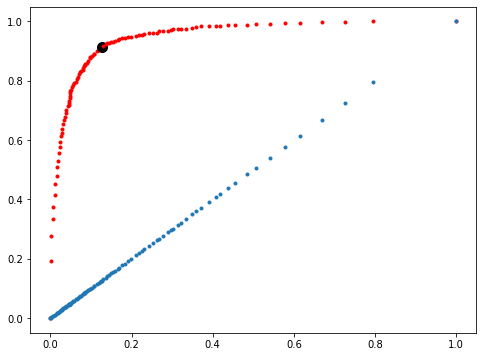

In [21]:
tprs = []
fprs = []
diffs = []
for x in np.linspace(0, 1, 101):
    fprs.append(classify_rates(X_train_sc, X_test_sc, y_train, y_test, x)[1])
    tprs.append(classify_rates(X_train_sc, X_test_sc, y_train, y_test, x)[0])
    xy2 = (fprs[-1] +  tprs[-1]) / 2
    
    #calculate distance between false positive (confusion_matrix[0][1])
    diffs.append(np.sqrt((xy2 - fprs[-1])**2 + (xy2 - tprs[-1])**2))
    
max_dist = diffs.index(np.max(diffs))
print(f"""With a threshold of {(max_dist - 1) / 100}: \n"""
      f"""\tYou\'ll have a True Positive Rate of {round(tprs[max_dist], 3)} \n"""
      f"""\tand a False Positive Rate of {round(fprs[max_dist], 3)}""")

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fprs[:max_dist], tprs[:max_dist], 'r.')
ax.plot(fprs[max_dist], tprs[max_dist], 'ko', ms=10)
ax.plot(fprs[max_dist + 1:], tprs[max_dist + 1:], 'r.')
ax.plot(fprs, fprs, '.');

Scikit-Learn's `roc_auc_score()` function will compute the area under the curve for us:

In [22]:
round(roc_auc_score(y_test, logreg.predict(X_test_sc)), 4)

0.8916

Let's compare our curve with scikit-learn's:

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict(X_test_sc))

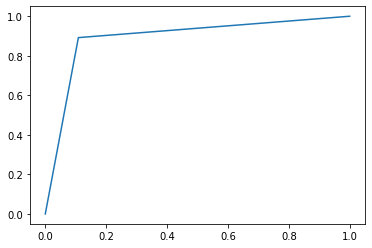

In [24]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr);

Scikit-Learn only shows us the optimal threshold, but it appears to be very similar to ours.